In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class ElasticNetRegression:
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=1000, tol=1e-4, learning_rate=0.01):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.coef_ = None
        self.intercept_ = None
    
    def _soft_threshold(self, x, lambda_):
        return np.sign(x) * np.maximum(np.abs(x) - lambda_, 0)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0
        
        X_mean = np.mean(X, axis=0)
        X_std = np.std(X, axis=0)
        X_std[X_std == 0] = 1
        X_scaled = (X - X_mean) / X_std
        
        y_mean = np.mean(y)
        y_scaled = y - y_mean
        
        l1_reg = self.alpha * self.l1_ratio
        l2_reg = self.alpha * (1 - self.l1_ratio)
        
        prev_loss = float('inf')
        for _ in range(self.max_iter):
            y_pred = np.dot(X_scaled, self.coef_)
            grad = -np.dot(X_scaled.T, (y_scaled - y_pred)) / n_samples
            grad_l2 = l2_reg * self.coef_
            
            self.coef_ = self._soft_threshold(
                self.coef_ - self.learning_rate * (grad + grad_l2),
                self.learning_rate * l1_reg
            )
            
            current_loss = self._compute_loss(X_scaled, y_scaled)
            if abs(prev_loss - current_loss) < self.tol:
                break
            prev_loss = current_loss
        
        self.coef_ = self.coef_ / X_std
        self.intercept_ = y_mean - np.dot(X_mean, self.coef_)
        return self
    
    def _compute_loss(self, X, y):
        n_samples = X.shape[0]
        y_pred = np.dot(X, self.coef_)
        mse = np.mean((y - y_pred) ** 2)
        l1_penalty = self.alpha * self.l1_ratio * np.sum(np.abs(self.coef_))
        l2_penalty = 0.5 * self.alpha * (1 - self.l1_ratio) * np.sum(self.coef_ ** 2)
        return mse + l1_penalty + l2_penalty
    
    def predict(self, X):
        return np.dot(X, self.coef_) + self.intercept_

In [5]:
def generate_sparse_data(n_samples=1000, n_features=20, n_informative=5, noise=0.5, random_state=42):
    np.random.seed(random_state)
    X = np.random.randn(n_samples, n_features)
    true_coef = np.zeros(n_features)
    informative_idx = np.random.choice(n_features, n_informative, replace=False)
    true_coef[informative_idx] = np.random.uniform(-2, 2, size=n_informative)
    X[:, informative_idx[0]] = X[:, informative_idx[1]] + np.random.normal(0, 0.1, size=n_samples)
    y = np.dot(X, true_coef) + noise * np.random.randn(n_samples)
    return X, y, true_coef

In [7]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
        
    def fit(self, X):
        X = np.array(X)
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=1)
        self.scale_[self.scale_ == 0] = 1.0
        return self
    
    def transform(self, X):
        X = np.array(X)
        return (X - self.mean_) / self.scale_
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)

def train_test_split(X, y, test_size=0.2, random_state=None):
    X, y = np.array(X), np.array(y)
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    return (X[train_indices], X[test_indices], 
            y[train_indices], y[test_indices])

In [9]:
def evaluate_model(model, X_train, X_test, y_train, y_test, true_coef):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mse = np.mean((y_train - y_train_pred) ** 2)
    test_mse = np.mean((y_test - y_test_pred) ** 2)
    train_r2 = 1 - train_mse / np.var(y_train)
    test_r2 = 1 - test_mse / np.var(y_test)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5)
    axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    axes[0, 0].set_xlabel('True Values')
    axes[0, 0].set_ylabel('Predictions')
    axes[0, 0].set_title(f'Training: True vs Predicted\nR² = {train_r2:.3f}')
    
    axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5)
    axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0, 1].set_xlabel('True Values')
    axes[0, 1].set_ylabel('Predictions')
    axes[0, 1].set_title(f'Test: True vs Predicted\nR² = {test_r2:.3f}')
    
    axes[1, 0].bar(np.arange(len(true_coef)) - 0.2, true_coef, 0.4, label='True', alpha=0.7)
    axes[1, 0].bar(np.arange(len(model.coef_)) + 0.2, model.coef_, 0.4, label='Estimated', alpha=0.7)
    axes[1, 0].set_xlabel('Feature Index')
    axes[1, 0].set_ylabel('Coefficient Value')
    axes[1, 0].set_title('True vs Estimated Coefficients')
    axes[1, 0].legend()
    
    residuals = y_test - y_test_pred
    axes[1, 1].hist(residuals, bins=50, density=True, alpha=0.7)
    axes[1, 1].set_xlabel('Residual Value')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Residuals Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }


Testing alpha=0.001, l1_ratio=0.1


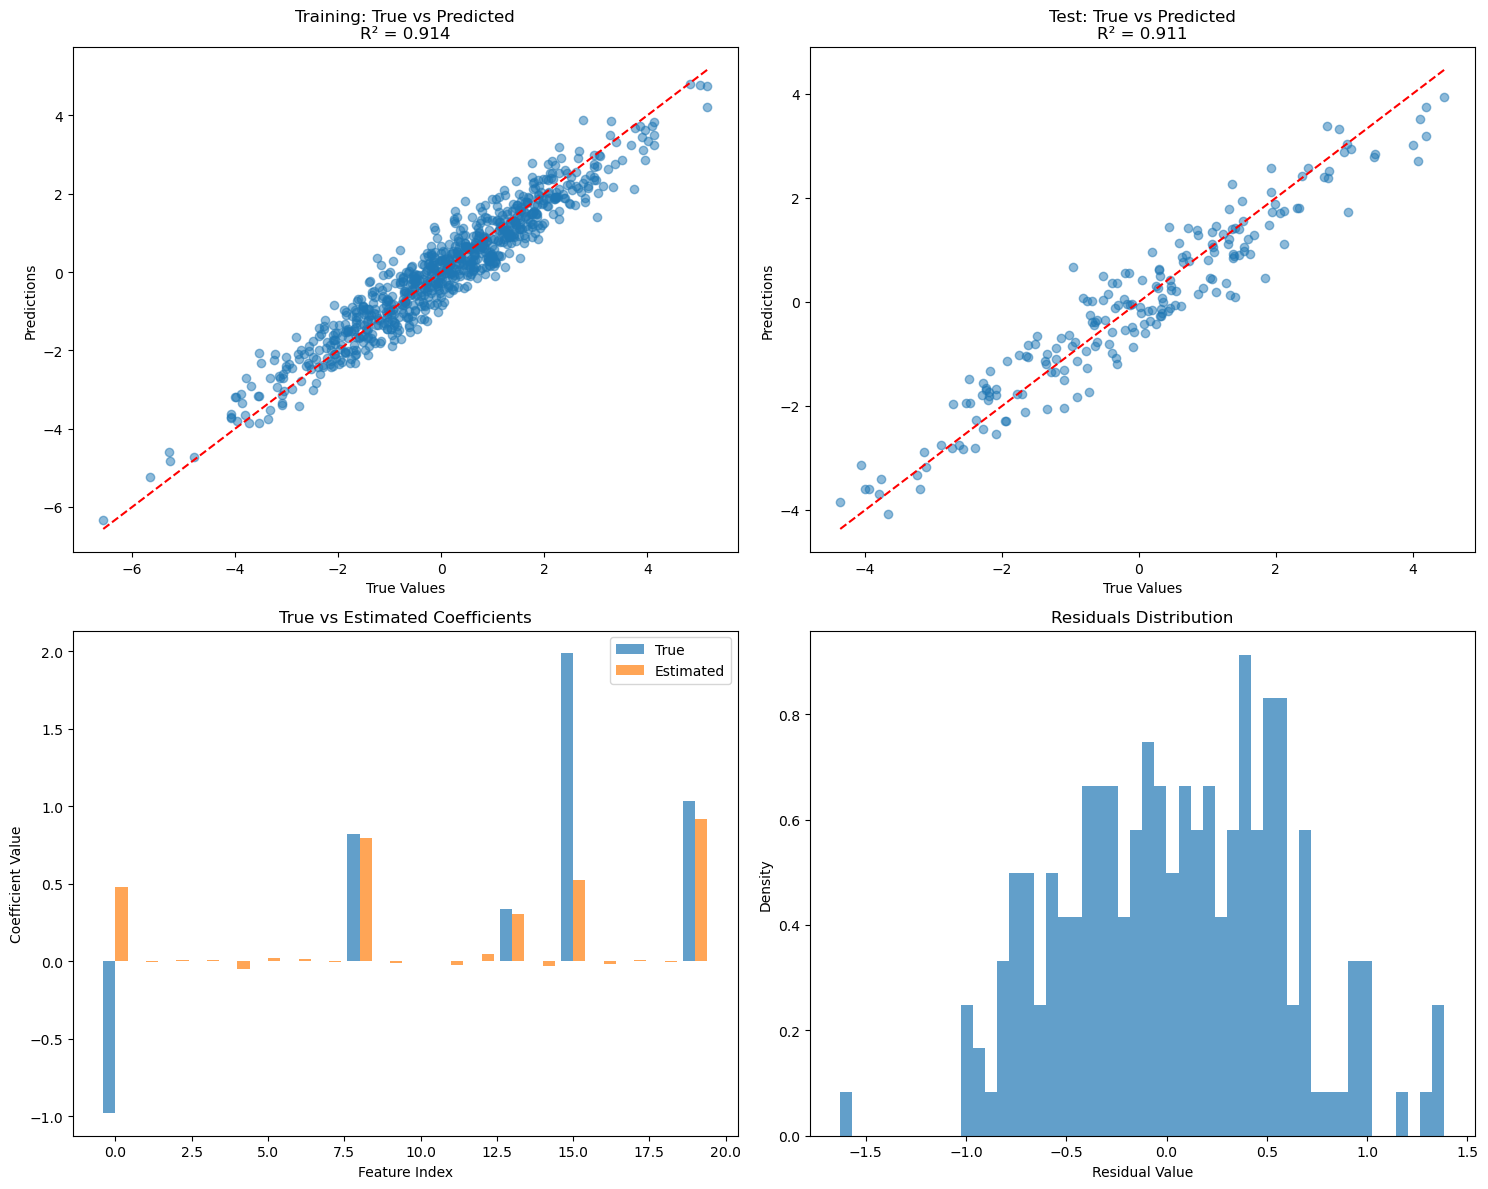

Test R²: 0.911
Test MSE: 0.298

Testing alpha=0.001, l1_ratio=0.5


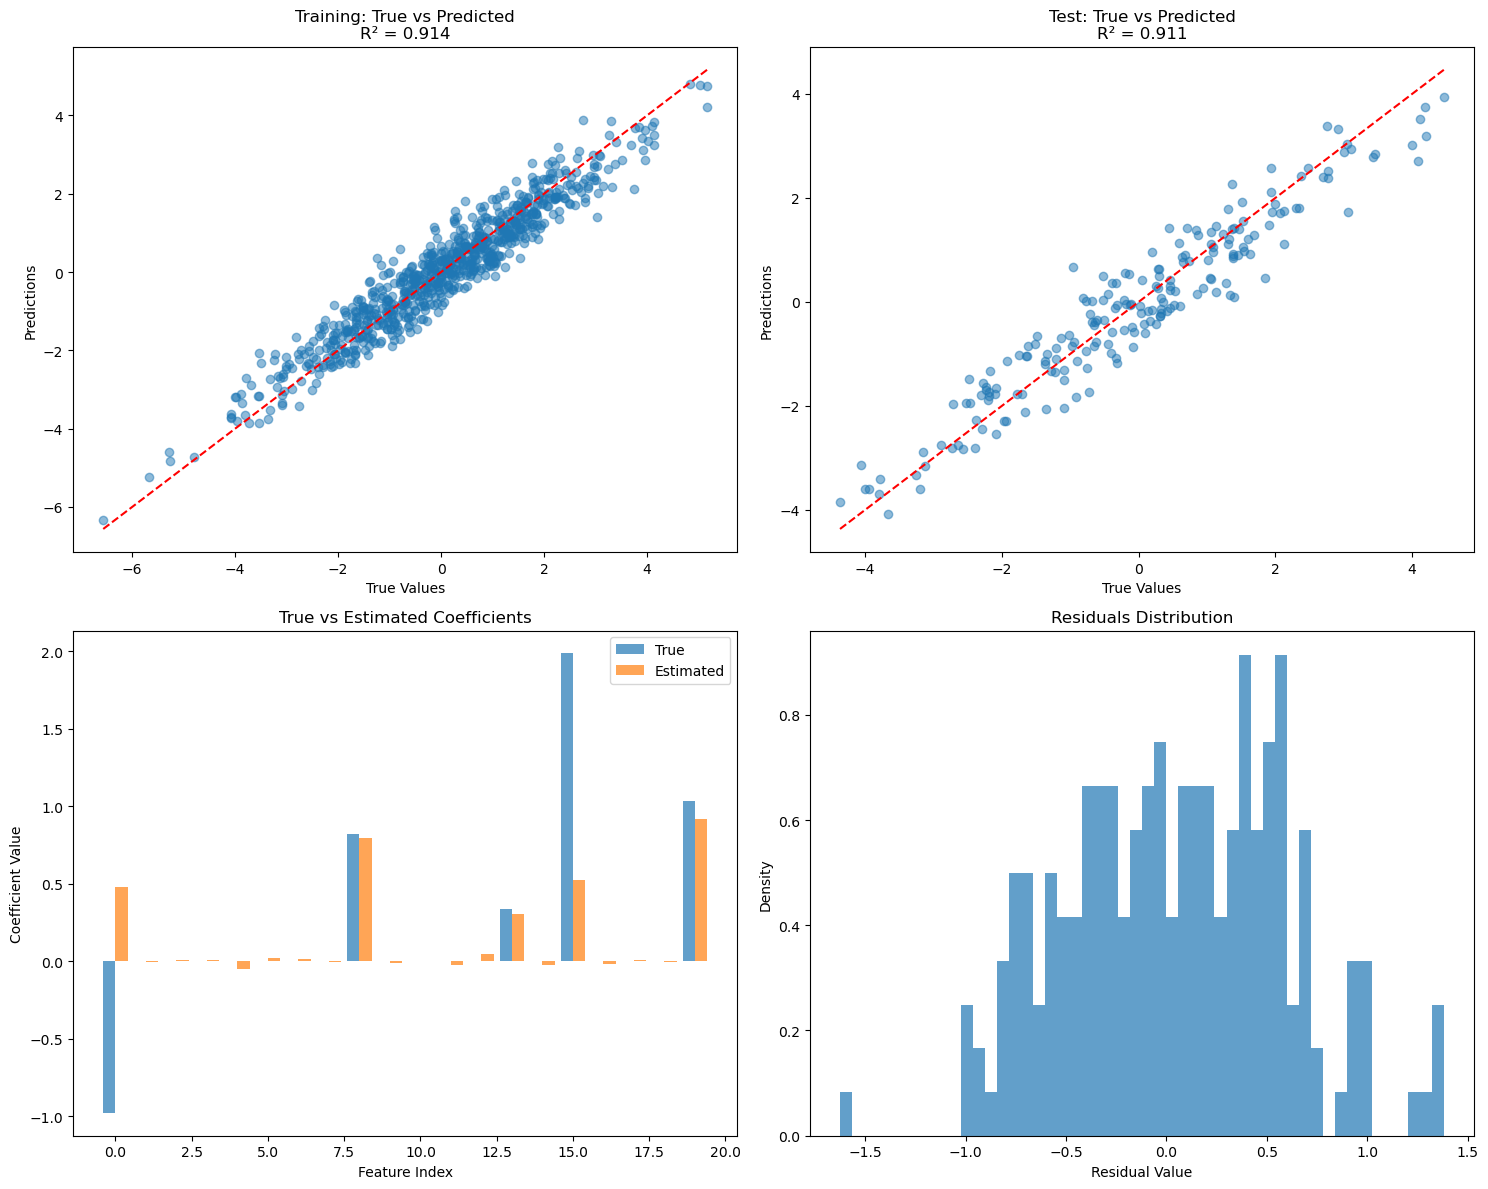

Test R²: 0.911
Test MSE: 0.297

Testing alpha=0.001, l1_ratio=0.9


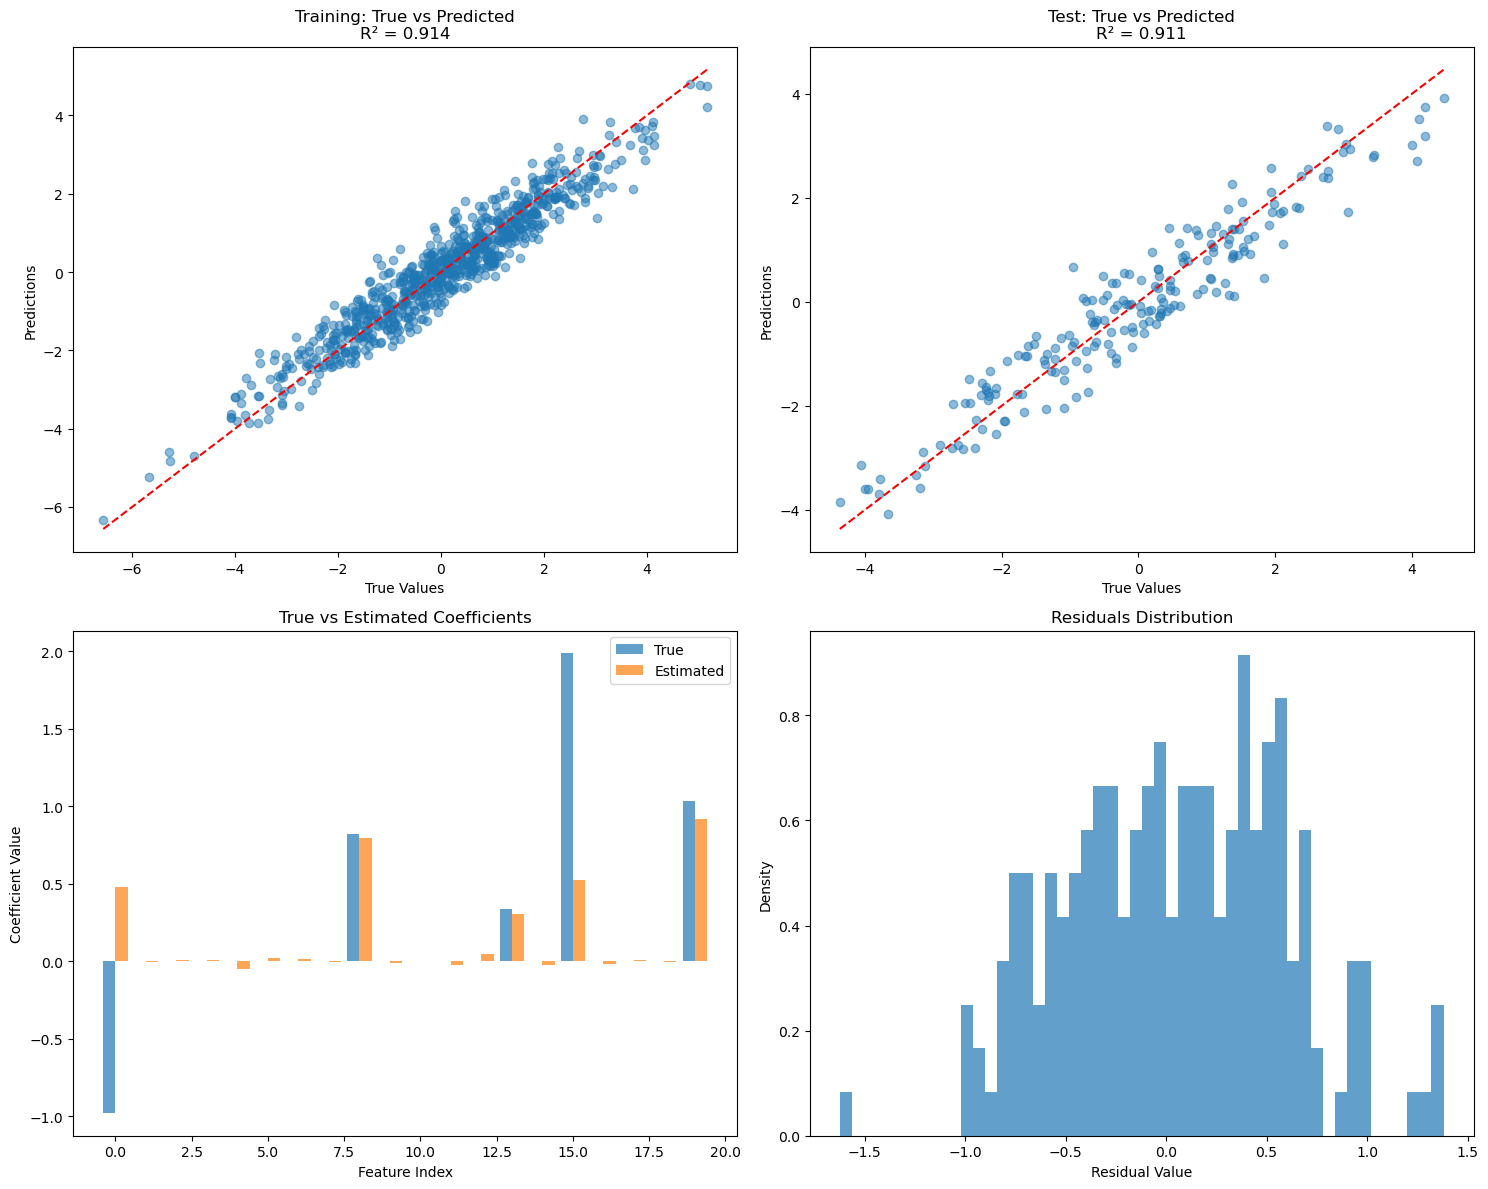

Test R²: 0.911
Test MSE: 0.297

Testing alpha=0.01, l1_ratio=0.1


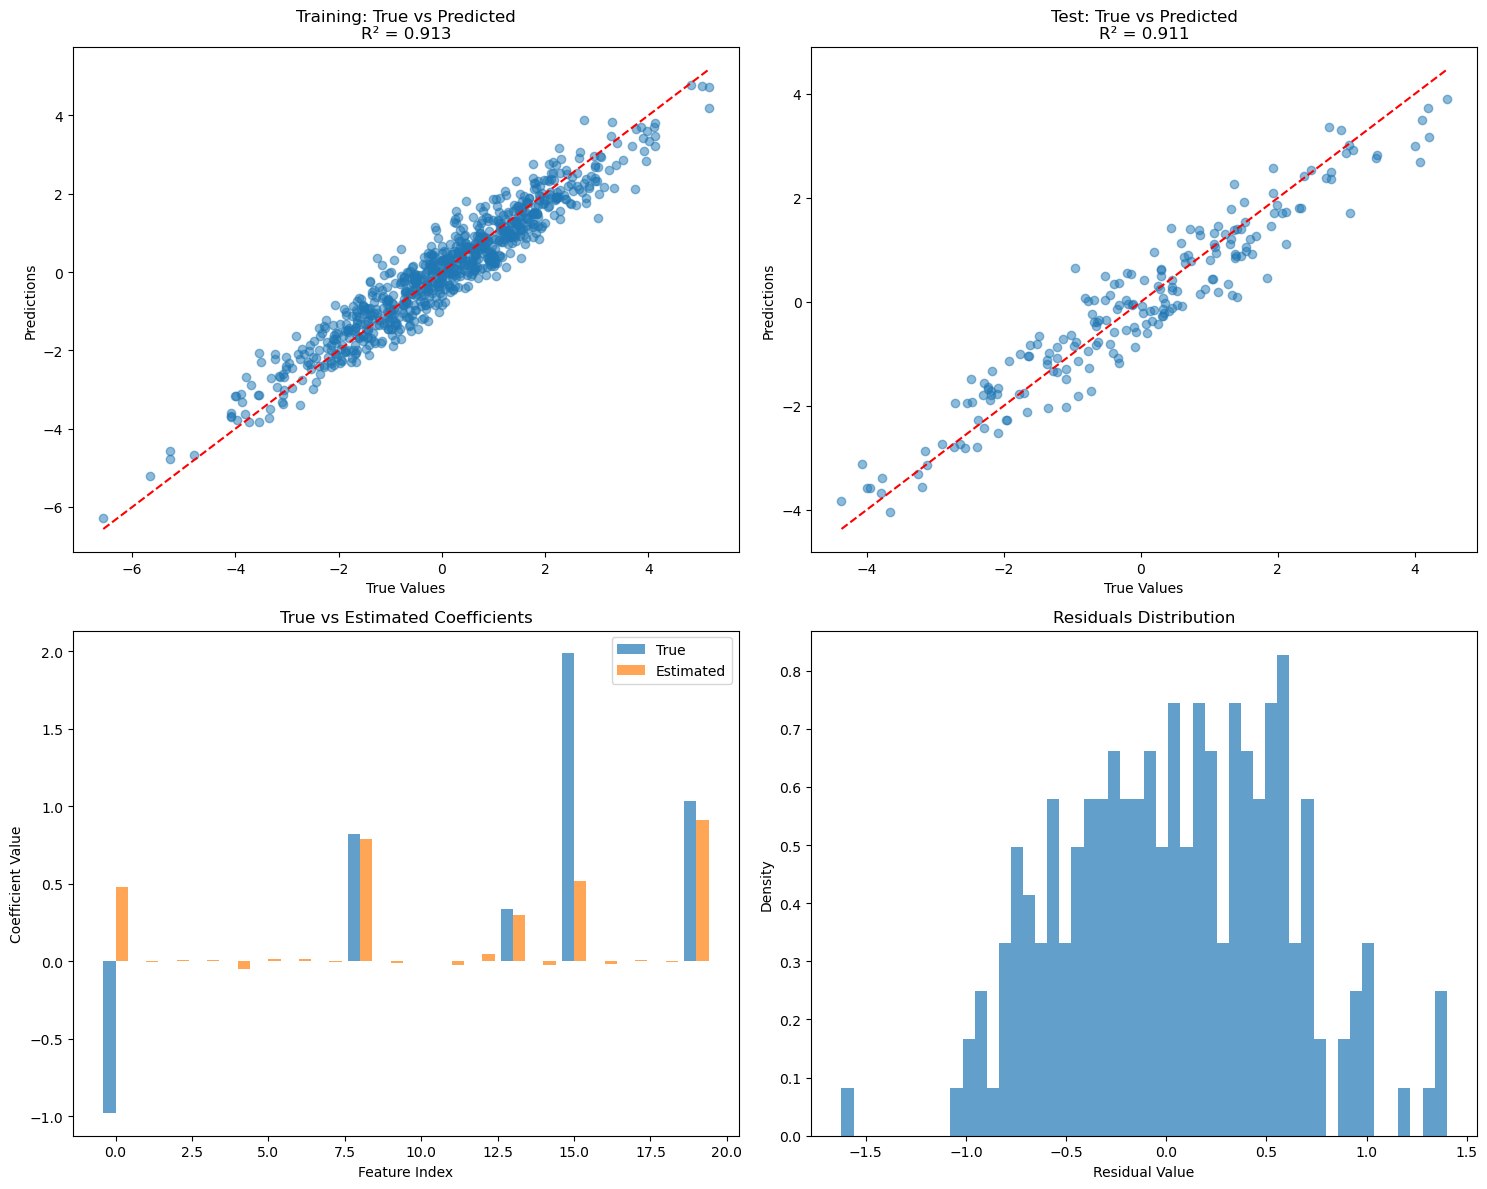

Test R²: 0.911
Test MSE: 0.299

Testing alpha=0.01, l1_ratio=0.5


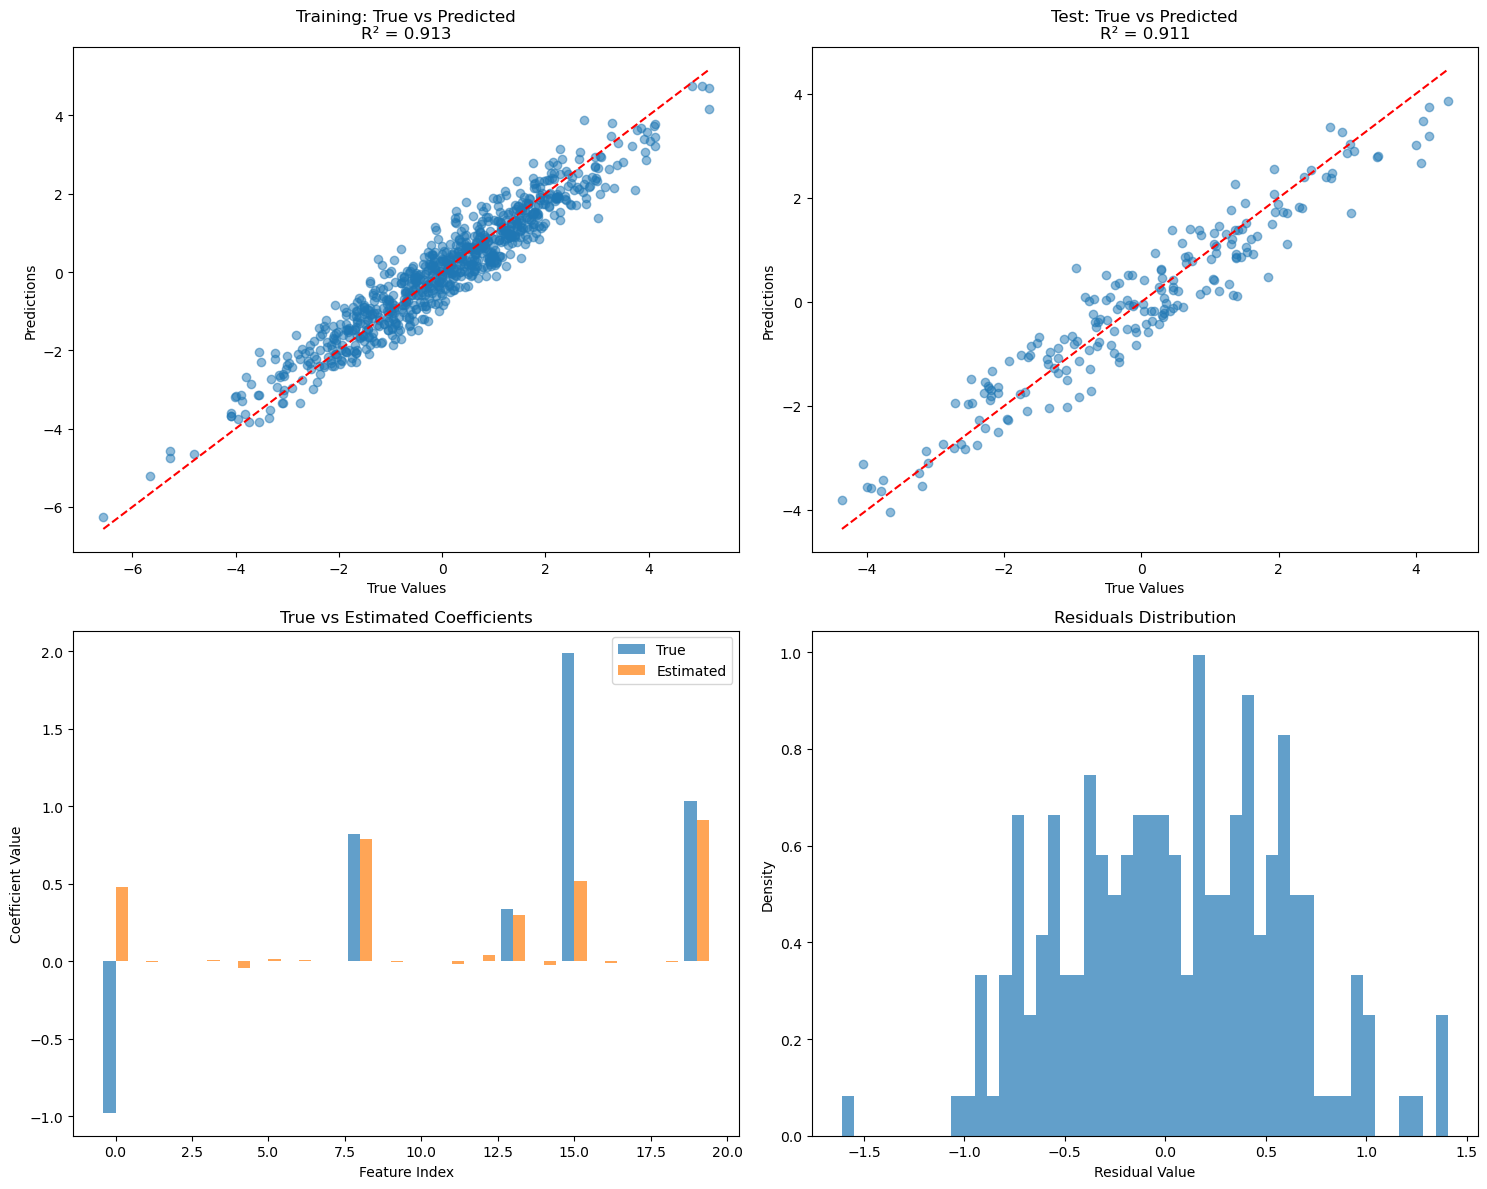

Test R²: 0.911
Test MSE: 0.296

Testing alpha=0.01, l1_ratio=0.9


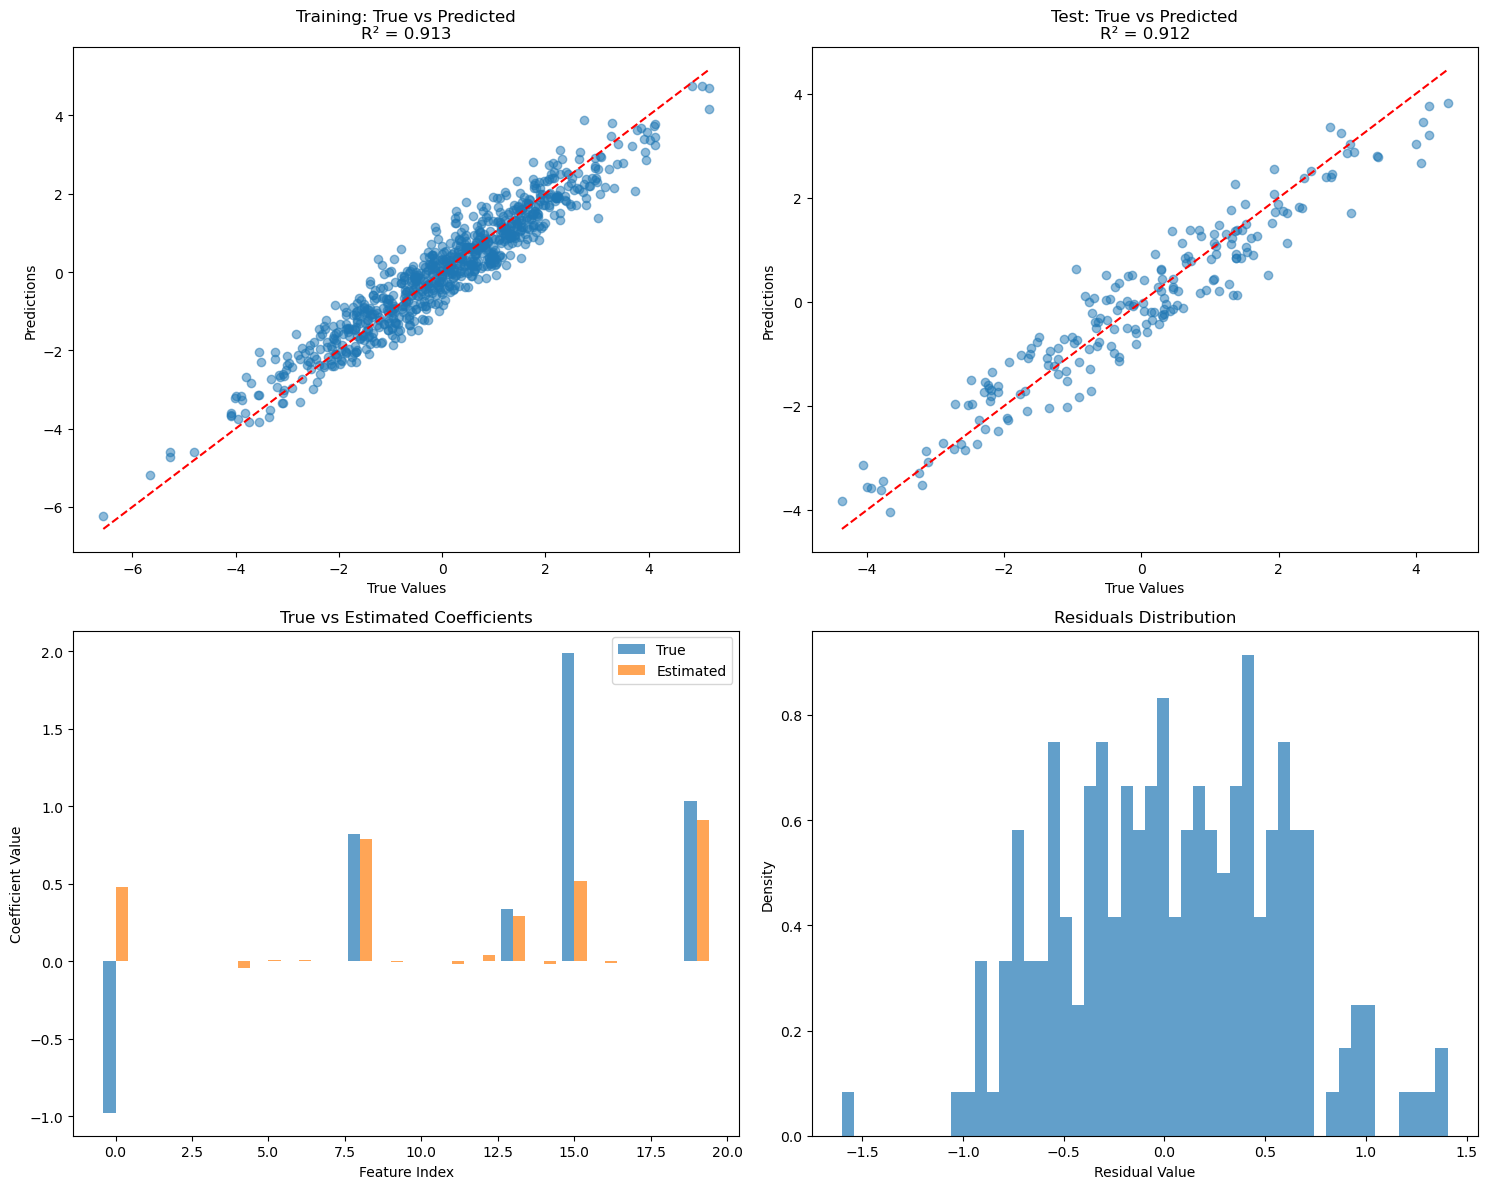

Test R²: 0.912
Test MSE: 0.294

Testing alpha=0.1, l1_ratio=0.1


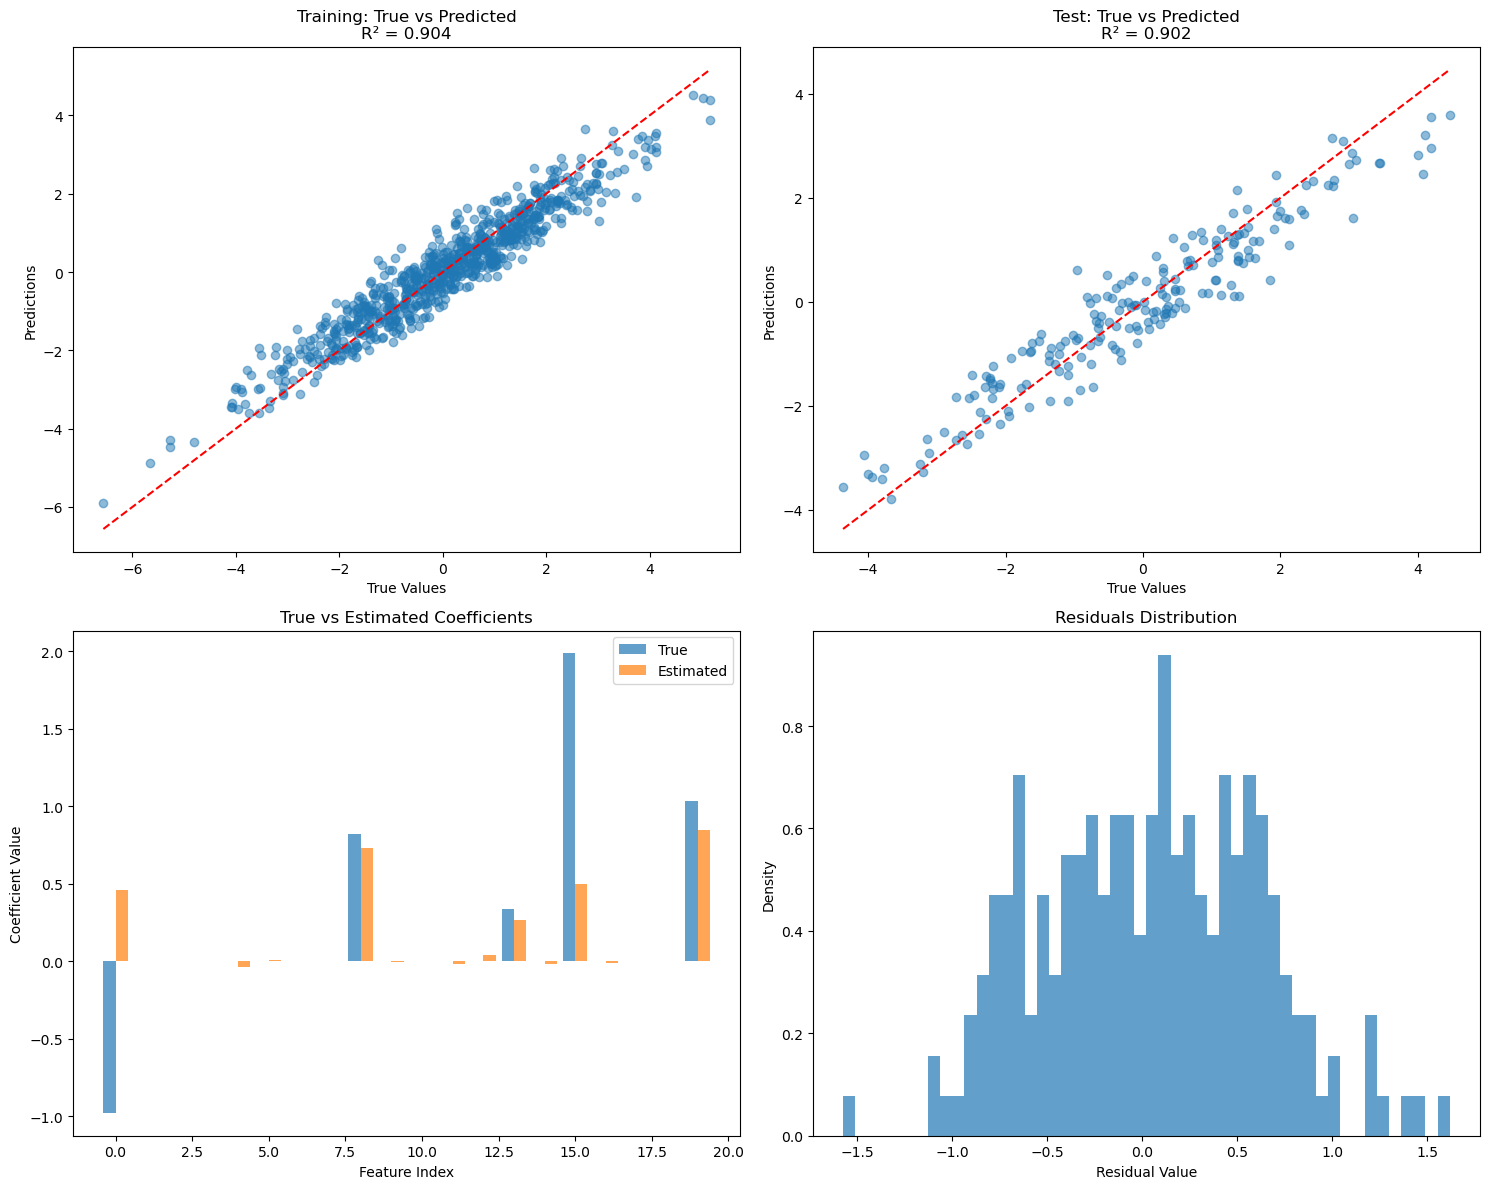

Test R²: 0.902
Test MSE: 0.329

Testing alpha=0.1, l1_ratio=0.5


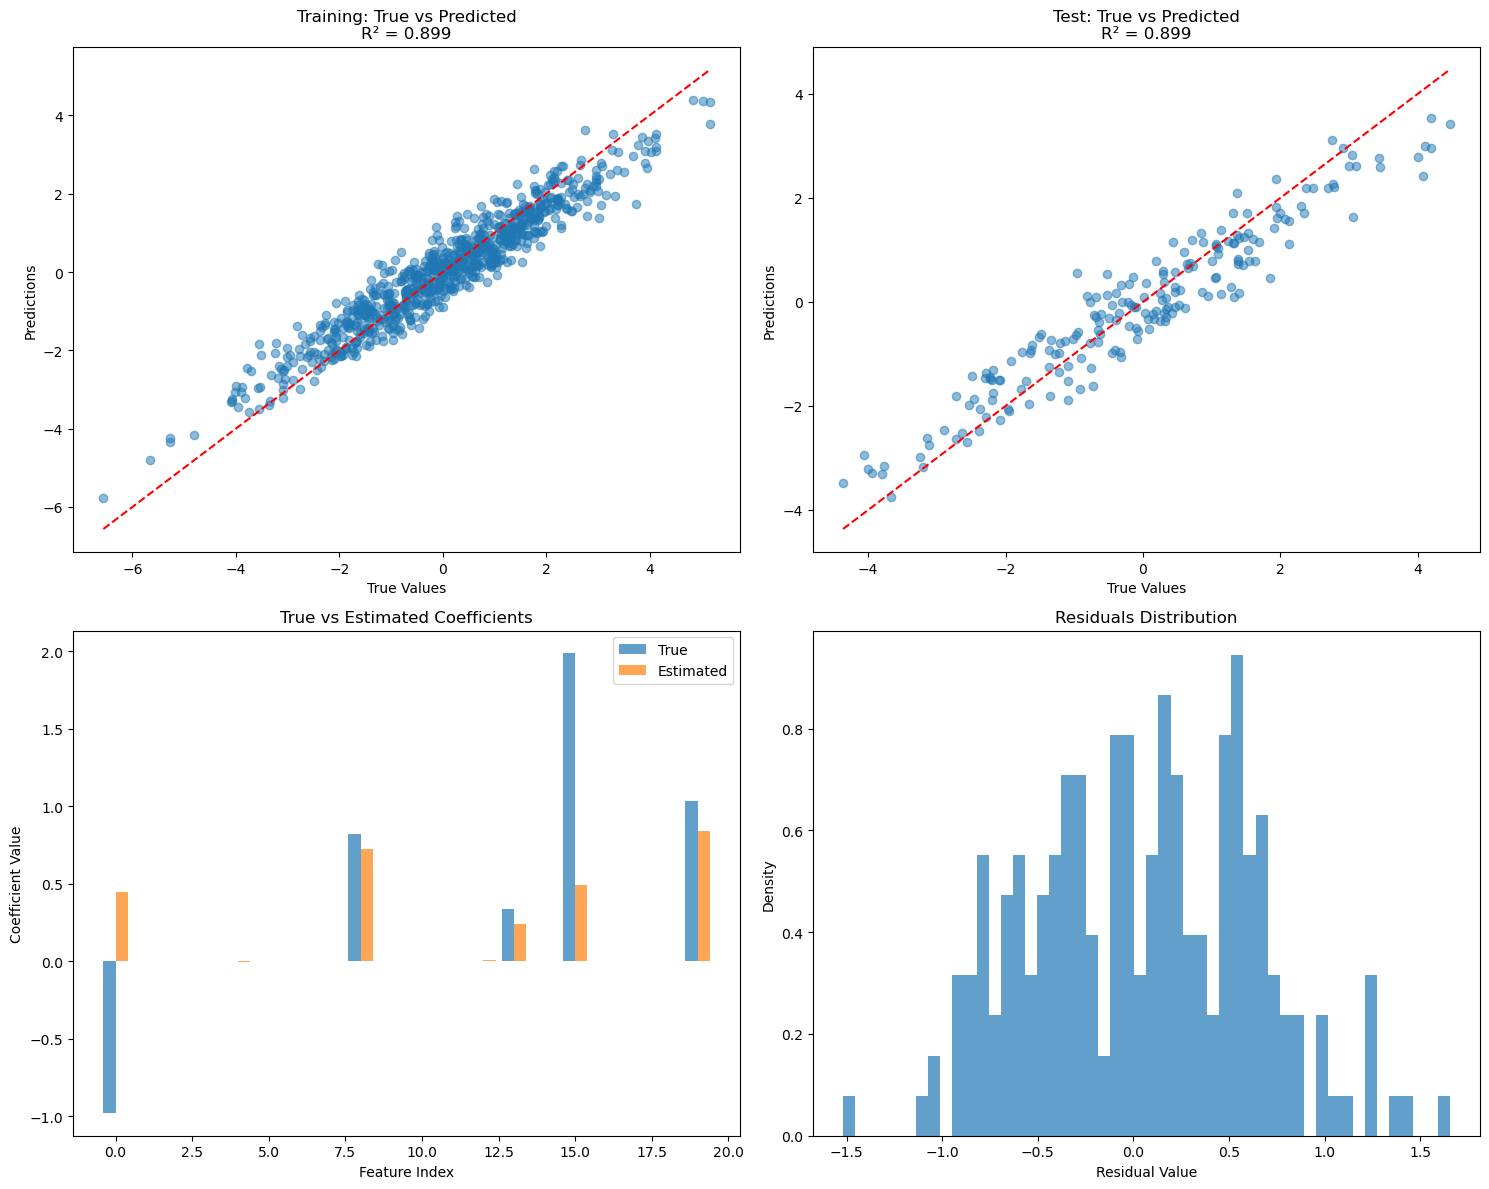

Test R²: 0.899
Test MSE: 0.337

Testing alpha=0.1, l1_ratio=0.9


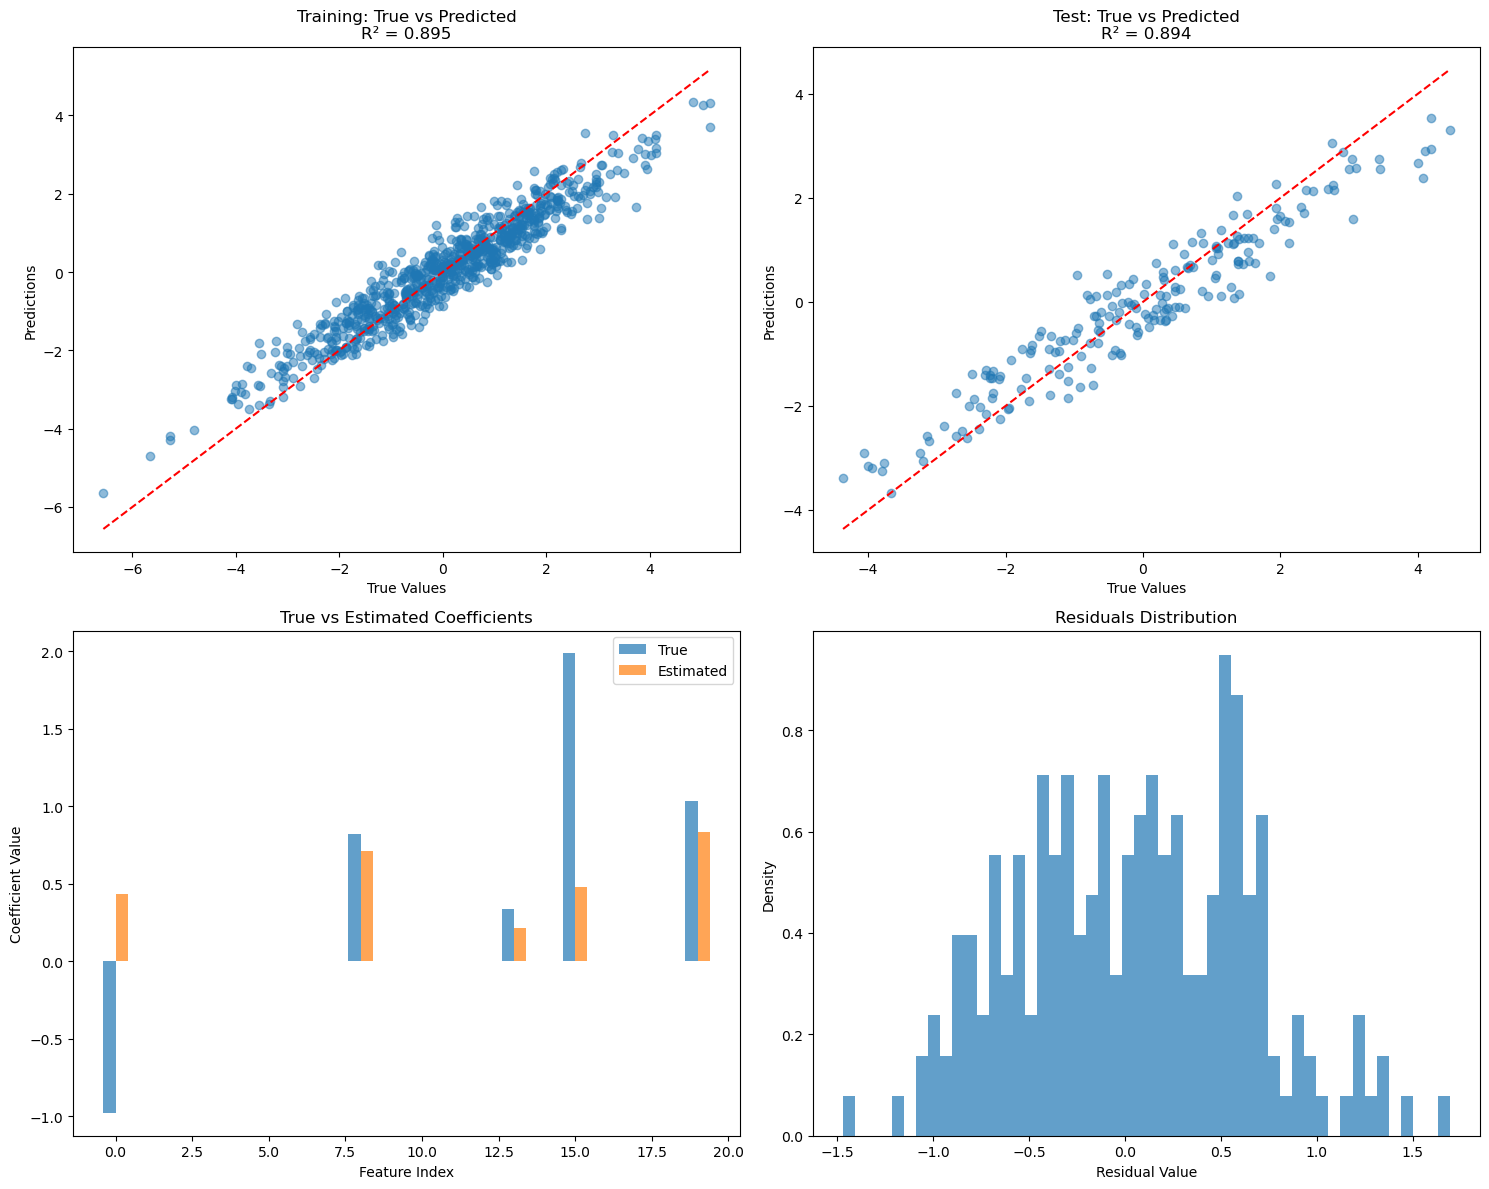

Test R²: 0.894
Test MSE: 0.354

Testing alpha=1.0, l1_ratio=0.1


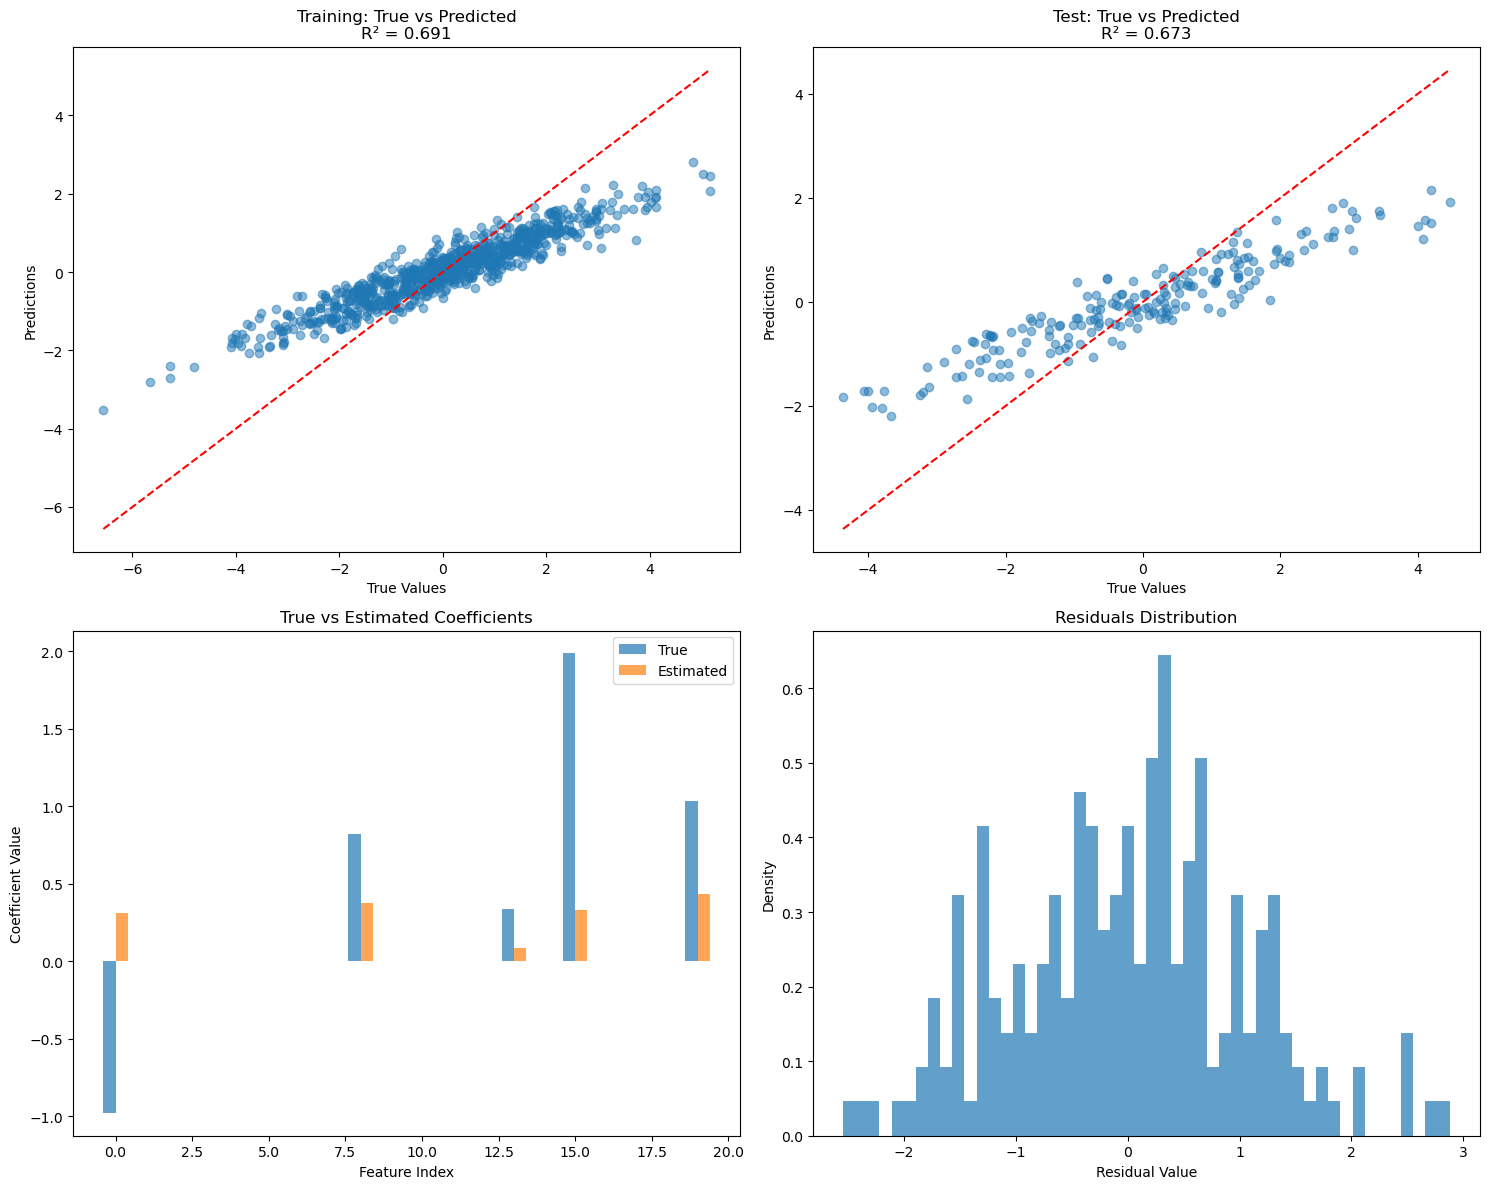

Test R²: 0.673
Test MSE: 1.095

Testing alpha=1.0, l1_ratio=0.5


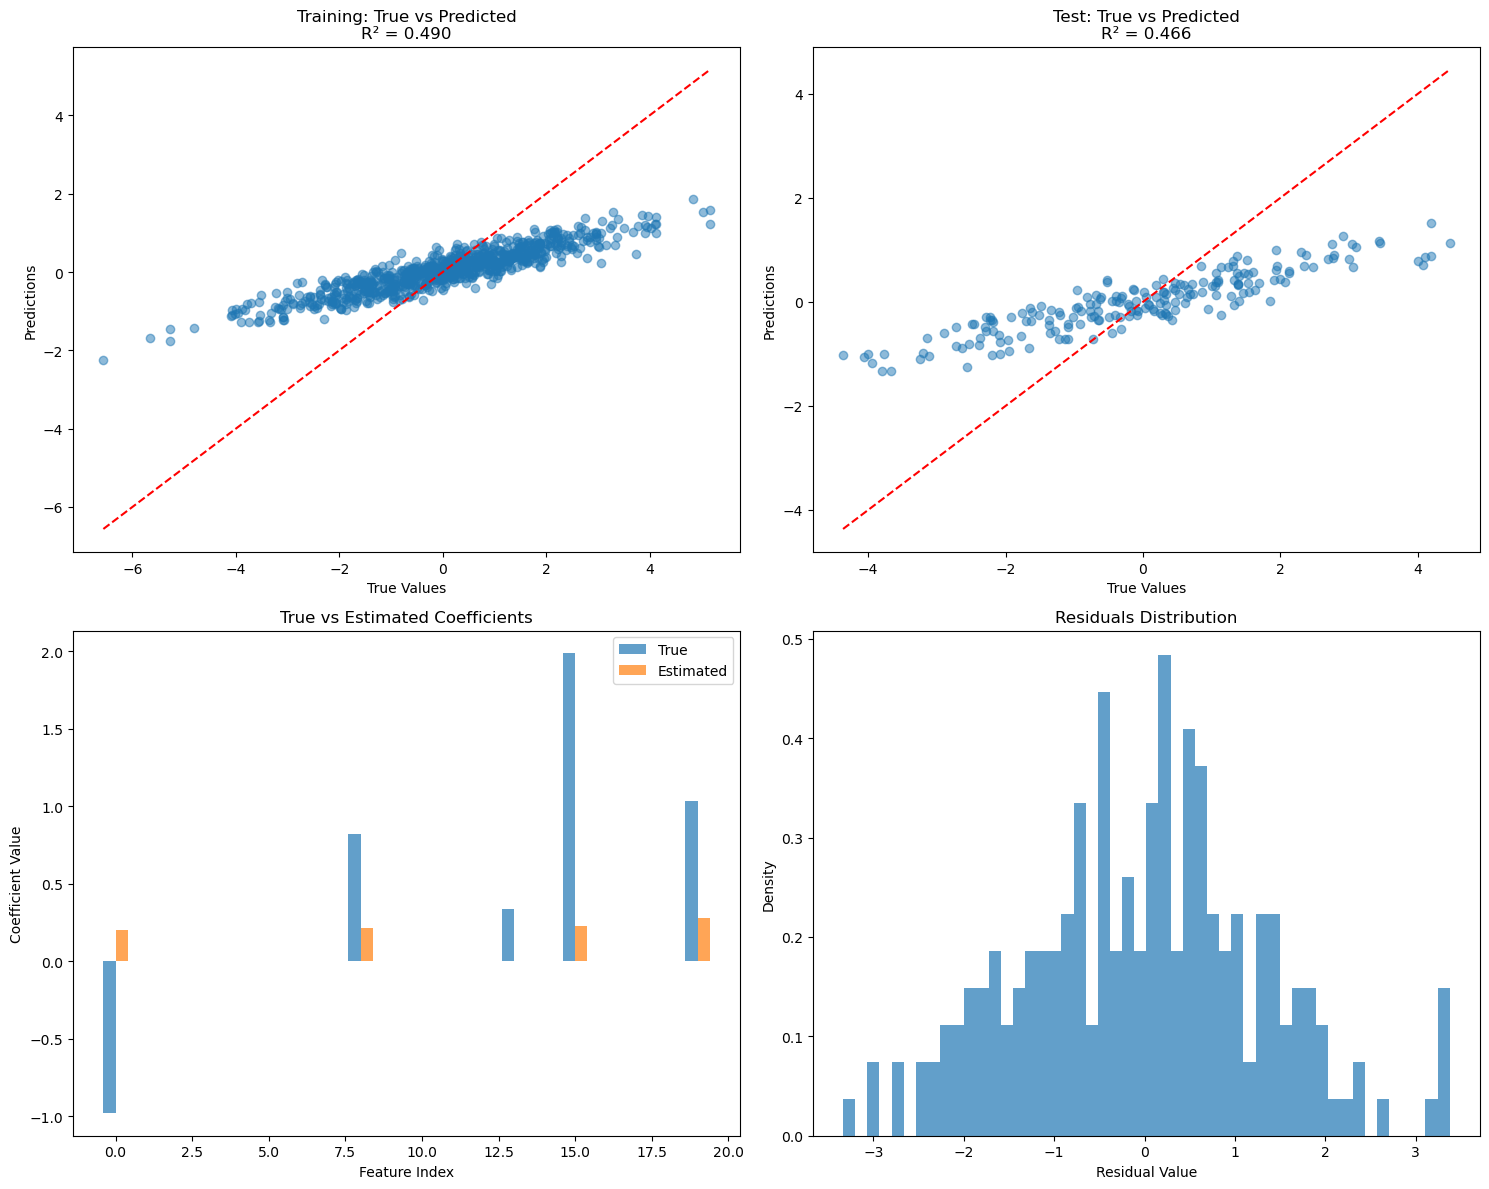

Test R²: 0.466
Test MSE: 1.788

Testing alpha=1.0, l1_ratio=0.9


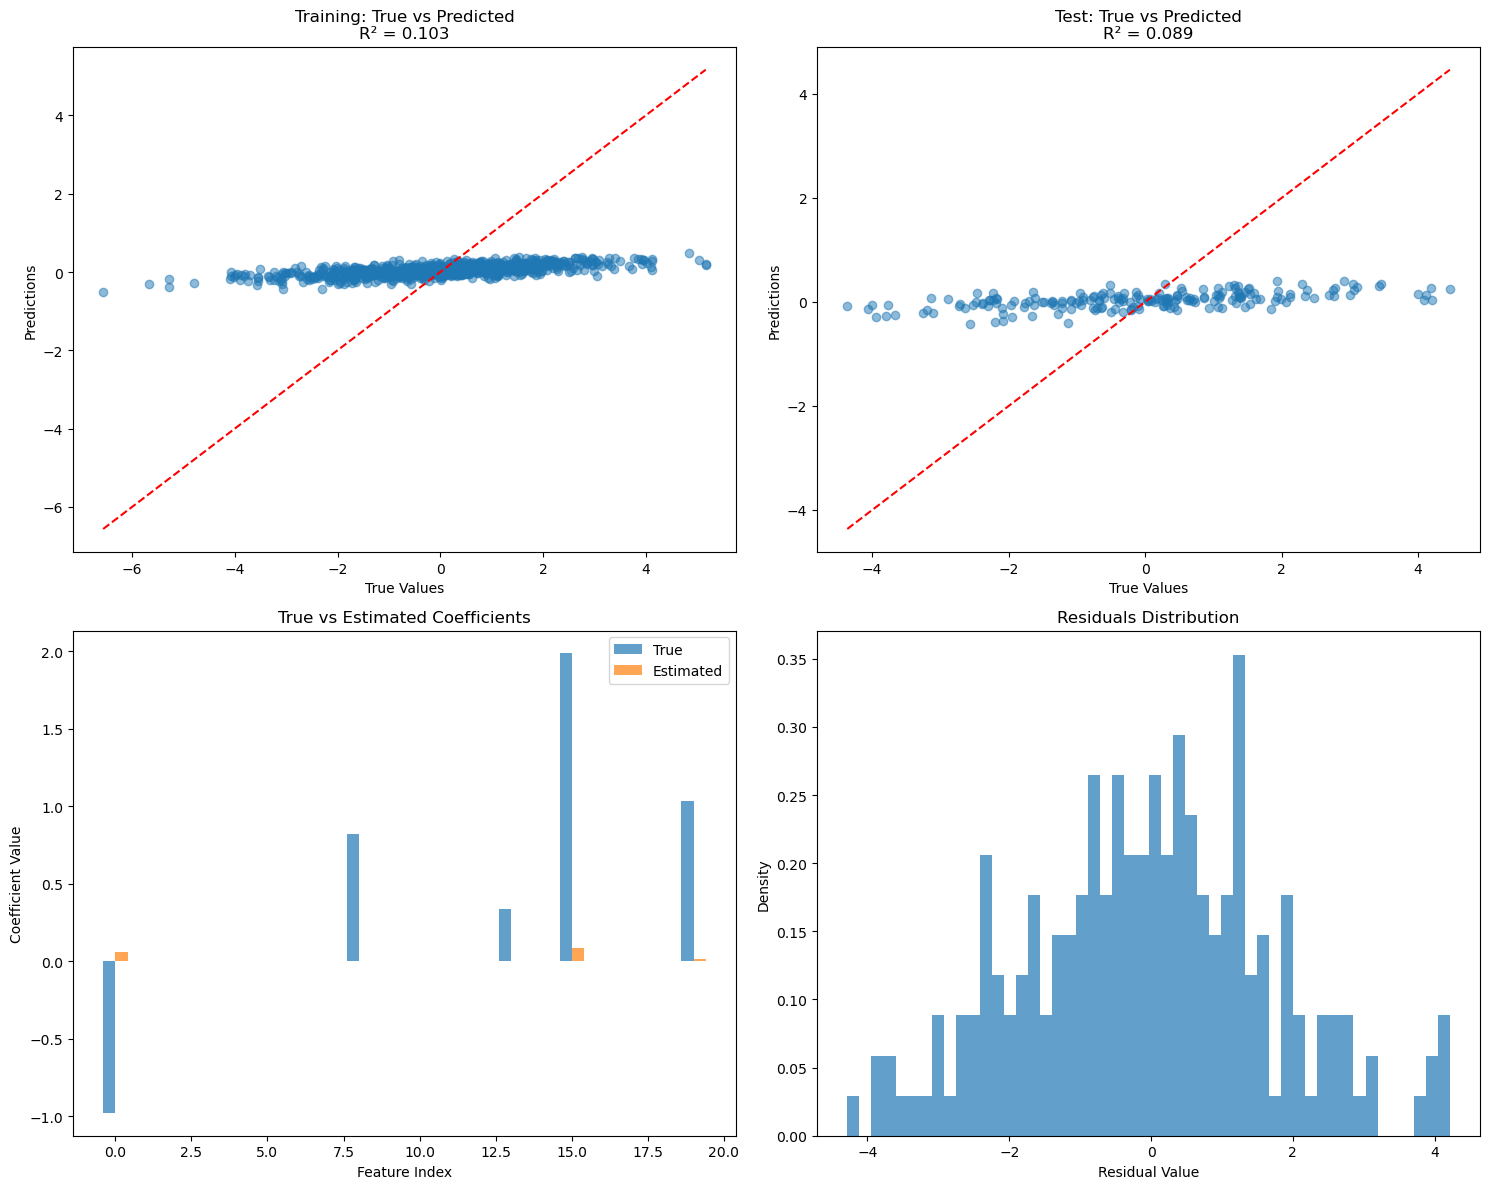

Test R²: 0.089
Test MSE: 3.048

Best parameters:
alpha: 0.01
l1_ratio: 0.9
Best Test R²: 0.912


In [11]:
if __name__ == "__main__":
    X, y, true_coef = generate_sparse_data(
        n_samples=1000,
        n_features=20,
        n_informative=5,
        noise=0.5
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    alphas = [0.001, 0.01, 0.1, 1.0]
    l1_ratios = [0.1, 0.5, 0.9]
    
    best_r2 = -float('inf')
    best_params = None
    
    results = {}
    for alpha in alphas:
        for l1_ratio in l1_ratios:
            print(f"\nTesting alpha={alpha}, l1_ratio={l1_ratio}")
            model = ElasticNetRegression(
                alpha=alpha,
                l1_ratio=l1_ratio,
                max_iter=1000,
                tol=1e-4,
                learning_rate=0.01
            )
            
            results[(alpha, l1_ratio)] = evaluate_model(
                model, X_train_scaled, X_test_scaled, y_train, y_test, true_coef
            )
            
            current_r2 = results[(alpha, l1_ratio)]['test_r2']
            print(f"Test R²: {current_r2:.3f}")
            print(f"Test MSE: {results[(alpha, l1_ratio)]['test_mse']:.3f}")
            
            if current_r2 > best_r2:
                best_r2 = current_r2
                best_params = (alpha, l1_ratio)
    
    print("\nBest parameters:")
    print(f"alpha: {best_params[0]}")
    print(f"l1_ratio: {best_params[1]}")
    print(f"Best Test R²: {best_r2:.3f}")